# Exercise: Predicting Lorenz system using RC

2020/11/04 - skim0119

[paper](https://arxiv.org/abs/1710.07313) - Section III example 1

### Contains
- Lorenz 1963 system define
- Sparse random Erdos-Renyi network
- Tikhonov Regularized Regression (with sklearn)
- RC implemented using nengo

### Difference with original paper
- Third coordinate (z) is not symmetrical.

## Table of Contents
* [1. Lorenz 1963 System](#1-bullet)
* [2. Sparse random Erdos-Renyi network](#2-bullet)
* [3. Reservoir Computing using Nengo](#3-bullet)
* [4. Training with Tikhonov Regularized Regression](#4-bullet)
* [5. Evaluation - Predict Future Data](#5-bullet)

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.stats as spst
from sklearn.linear_model import Ridge

import nengo

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

### Hyperparameters

In [2]:
# Random Seed
seed = 100

# Lorenz System Parameters
v_init = np.array([0.0,1,20])
dt = 0.02
T_total = 125
T_train = 100

# RC model Parameters
num_reservoir_neurons = 300  # Dr
spectral_radius = 1.2  # rho

# Training Loss Hyperparameter
beta = 1e-1

## 1. Lorenz 1963 System <a class="anchor" id="1-bullet"></a>

In [3]:
def lorenz(x, y, z, s=10, r=28, b=8.0/3.0):
    ''' Lorenz Iterator
    Parameters
    ----------
       x, y, z: a point in three dimensional space
       s, r, b: lorenz attractor
    Returns
    -------
       x_dot, y_dot, z_dot: partial derivatives
    '''
    x_dot = s*(y - x)
    y_dot = x * (r - z) - y
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

In [4]:
def iterator(func, initial, dt=0.02, T=100, **kwargs):
    time = 0
    while time < T:
        v_dot = lorenz(*initial, **kwargs)
        vs = initial + np.array(v_dot) * dt
        time += dt
        yield initial, vs
        initial = vs

In [5]:
# Data Generate
xs, ys, zs = [], [], []
us = []
vs = []
for u, v in iterator(lorenz, v_init, dt=dt, T=T_total):
    xs.append(v[0])
    ys.append(v[1])
    zs.append(v[2])
    us.append(u)
    vs.append(v)
xs = np.array(xs)
ys = np.array(ys)
zs = np.array(zs)
us = np.array(us)
vs = np.array(vs)

Text(0, 0.5, 'x')

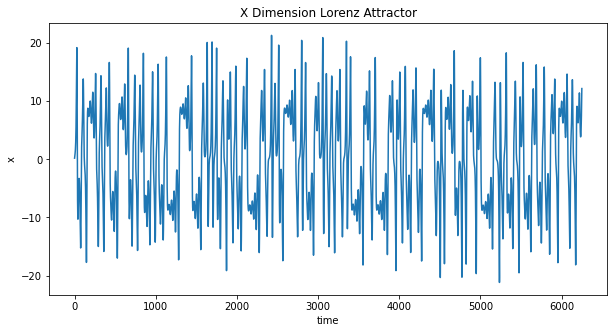

In [6]:
plt.figure(figsize=(10,5))
plt.plot(xs)
plt.title('X Dimension Lorenz Attractor')
plt.xlabel('time')
plt.ylabel('x')

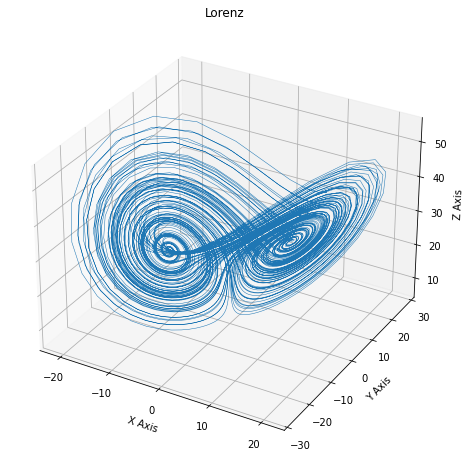

In [7]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")

ax.set_zlabel("Z Axis")
ax.set_title("Lorenz")

plt.show()

## 2. Sparse random Erdos-Renyi network <a class="anchor" id="2-bullet"></a>

In [8]:
def generate_innerconnection(n, alpha=(-1,1), seed=0, degree=6, spectral_radius=0.9):
    ''' Generate Inner-connection Adjacency Matrix
    Design to generate sparsly connected graph according
    to Erdos-Renyi (ER) Random Graph
    
    Note
    ----
    Density of the graph means the density of connections.
    In scipy sparse package, density means density of non-zero elements.
    
    Parameters
    ----------
    n : number of neuron in reservoir
    alpha : lower/upper bound (equivalent to 'a' in the paper)
        Note that the bound will be re-adjusted to fit spectral radius.
    seed : random seed
    degree : ER graph degree (N*density=degree)
    spectral_radius : spectral radius (equivalent to 'rho' in the paper)
    '''
    
    if isinstance(alpha, float) or isinstance(alpha, int):
        alpha = (-alpha, alpha)
    
    rho = min(degree / n, 1.0)  # Density (clip [0,1))
    
    # Random Seed
    np_random = np.random.RandomState(seed)  # Random Generator
    
    # Generate Adjacency (with weights)
    rvs = spst.uniform(alpha[0], alpha[1]).rvs
    A = sps.random(n, n, density=rho, random_state=np_random, data_rvs=rvs)
    
    # Fit Spectral Radius
    E, _ = sps.linalg.eigs(A)
    A *= spectral_radius / np.abs(E).max()  # (TODO) I'm not sure this is 'sparse-friendly' way
    
    return A

def generate_coupler(n, m, alpha=(-1,1), seed=0):
    if isinstance(alpha, float) or isinstance(alpha, int):
        alpha = (-alpha, alpha)
    np_random = np.random.RandomState(seed)
    coupler = np_random.uniform(alpha[0], alpha[1], (n, m))
    return coupler

density : 0.02


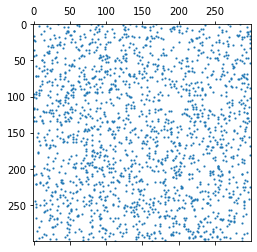

In [9]:
A = generate_innerconnection(300, seed=seed, spectral_radius=spectral_radius)
print(f'density : {A.nnz / np.prod(A.shape)}')
plt.spy(A, markersize=1)

In [10]:
W_in = generate_coupler(num_reservoir_neurons, 3, alpha=1, seed=seed)  # Dr x D
W_out = generate_coupler(3, num_reservoir_neurons, alpha=1, seed=seed)  # D x Dr

## 3. Reservoir Computing using Nengo <a class="anchor" id="3-bullet"></a>

### Data Preperation

In [11]:
step_train = int(T_train / dt)
u_train, u_test = us[:step_train], us[step_train:]
v_train, v_test = vs[:step_train], vs[step_train:]

feedback = [np.zeros(3)]  # (TODO) - remove global variale. find better way
def input_func(time):
    if int(time/dt) >= step_train:
        return feedback[0]
    else:
        return u_train[int(time/dt)]

### RC Model

In [12]:
network = nengo.Network(label='Lorenz63 Predictor')
with network:
    in_node = nengo.Node(input_func, size_out=3)
    reservoir = nengo.Ensemble(n_neurons=num_reservoir_neurons, dimensions=3, neuron_type=nengo.RectifiedLinear())
    conn_in = nengo.Connection(in_node, reservoir.neurons, synapse=0, transform=W_in)  # Decode
    conn_res = nengo.Connection(reservoir.neurons, reservoir.neurons,
                                synapse=0, transform=A.todense())  # Direct
    state_probe = nengo.Probe(reservoir.neurons, synapse=0.1, label='r')

### Pre-trained Simulation

In [20]:
# Pre-trained Simulation
with nengo.Simulator(network, dt=dt, optimize=False) as sim:
    sim.run(T_train)
Ar = sim.data[state_probe]
r_next = np.tanh(Ar)
v_out = r_next@W_out.T
    
'''
# process third row
r_third = r_next.copy()
r_third[num_reservoir_neurons//2:] = r_next[num_reservoir_neurons//2:] ** 2
v_out[:,2:] = r_third @ W_out[2:,:].T
'''

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

'\n# process third row\nr_third = r_next.copy()\nr_third[num_reservoir_neurons//2:] = r_next[num_reservoir_neurons//2:] ** 2\nv_out[:,2:] = r_third @ W_out[2:,:].T\n'

Before Training:
2-norm error : 1411.5425635560234
inf-norm error : 80.46259882813325


Text(0.5, 0, 'time')

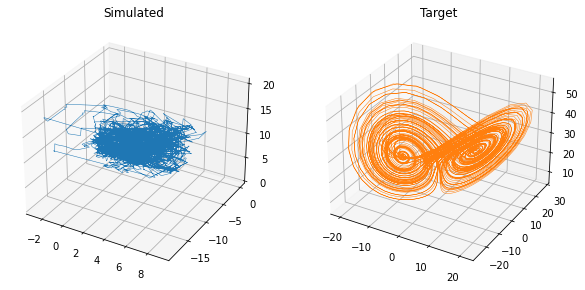

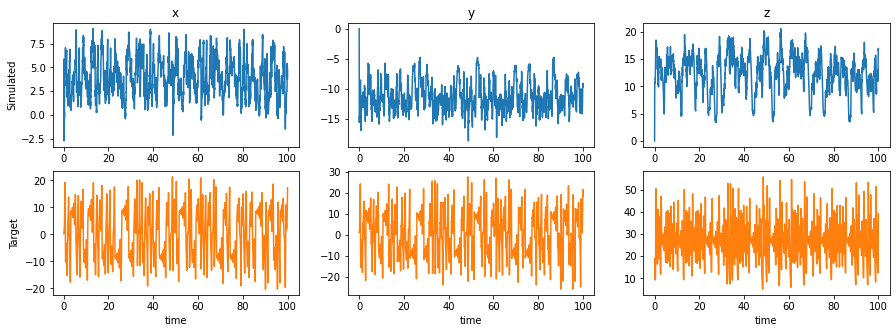

In [21]:
# Plot
print('Before Training:')
print(f'2-norm error : {np.linalg.norm(v_out-v_train, 2)}')
print(f'inf-norm error : {np.linalg.norm(v_out-v_train, np.inf)}')

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection=Axes3D.name)
ax.plot(*v_out.T, lw=0.5)
ax.set_title('Simulated')
ax = fig.add_subplot(122, projection=Axes3D.name)
ax.plot(*v_train.T, 'tab:orange', lw=0.5)
ax.set_title('Target')

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(231)
ax.plot(sim.trange(), v_out[:,0])
ax.set_title('x')
ax.set_ylabel('Simulated')
ax = fig.add_subplot(234)
ax.plot(sim.trange(), v_train[:,0], 'tab:orange')
ax.set_ylabel('Target')
ax.set_xlabel('time')
ax = fig.add_subplot(232)
ax.plot(sim.trange(), v_out[:,1])
ax.set_title('y')
ax = fig.add_subplot(235)
ax.plot(sim.trange(), v_train[:,1], 'tab:orange')
ax.set_xlabel('time')
ax = fig.add_subplot(233)
ax.plot(sim.trange(), v_out[:,2])
ax.set_title('z')
ax = fig.add_subplot(236)
ax.plot(sim.trange(), v_train[:,2], 'tab:orange')
ax.set_xlabel('time')

## 4. Training with Tikhonov Regularized Regression <a class="anchor" id="4-bullet"></a>

In [15]:
clf = Ridge(alpha=beta)
clf.fit(r_next, v_train)
print(f'score (R^2) : {clf.score(r_next, v_train)}')
v_out = clf.predict(r_next)

score (R^2) : 0.8605015630475892


After Training:
2-norm error : 288.2182220939651
inf-norm error : 40.657228630805


Text(0.5, 0, 'time')

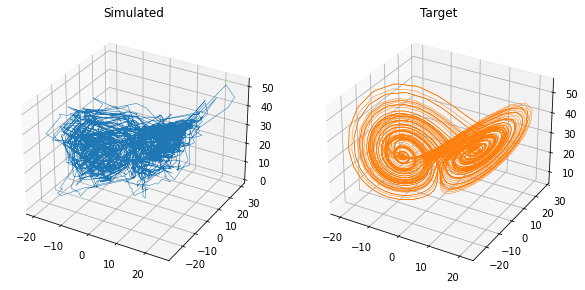

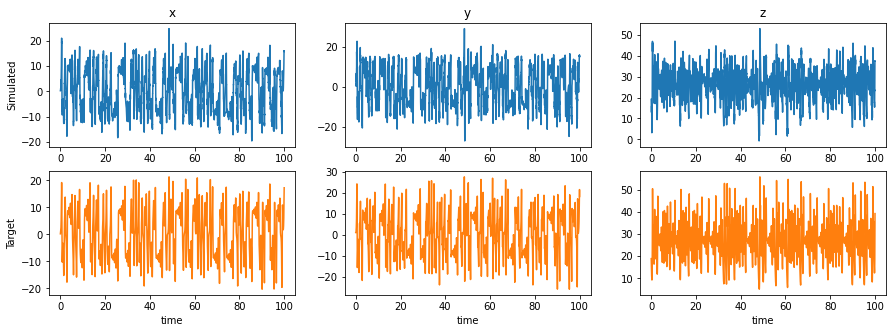

In [16]:
# Plot
print('After Training:')
print(f'2-norm error : {np.linalg.norm(v_out-v_train, 2)}')
print(f'inf-norm error : {np.linalg.norm(v_out-v_train, np.inf)}')

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection=Axes3D.name)
ax.plot(*v_out.T, lw=0.5)
ax.set_title('Simulated')
ax = fig.add_subplot(122, projection=Axes3D.name)
ax.plot(*v_train.T, 'tab:orange', lw=0.5)
ax.set_title('Target')

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(231)
ax.plot(sim.trange(), v_out[:,0])
ax.set_title('x')
ax.set_ylabel('Simulated')
ax = fig.add_subplot(234)
ax.plot(sim.trange(), v_train[:,0], 'tab:orange')
ax.set_ylabel('Target')
ax.set_xlabel('time')
ax = fig.add_subplot(232)
ax.plot(sim.trange(), v_out[:,1])
ax.set_title('y')
ax = fig.add_subplot(235)
ax.plot(sim.trange(), v_train[:,1], 'tab:orange')
ax.set_xlabel('time')
ax = fig.add_subplot(233)
ax.plot(sim.trange(), v_out[:,2])
ax.set_title('z')
ax = fig.add_subplot(236)
ax.plot(sim.trange(), v_train[:,2], 'tab:orange')
ax.set_xlabel('time')

## 5. Evaluation - Predict Future Data <a class="anchor" id="5-bullet"></a>

In [17]:
v_out = []
with nengo.Simulator(network, dt=dt, optimize=False) as sim:
    for _ in range(int(T_total/dt)+1):
        sim.step()
        Ar = sim.data[state_probe][-1]
        r_next = np.tanh(Ar)
        v = clf.predict(r_next[None,:])
        v_out.append(v[0])
        feedback[0] = v
v_out = np.array(v_out)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

After Training - Evaluation:
2-norm error : 1211.849259693866
inf-norm error : 131.88082870602915


Text(0.5, 0, 'time')

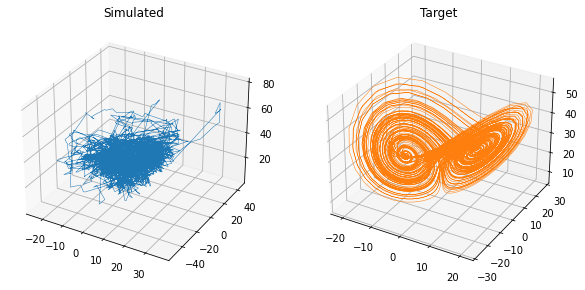

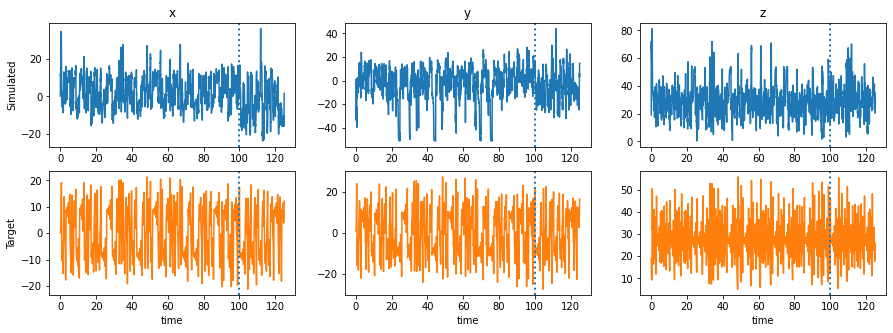

In [18]:
# Plot
print('After Training - Evaluation:')
print(f'2-norm error : {np.linalg.norm(v_out-vs, 2)}')
print(f'inf-norm error : {np.linalg.norm(v_out-vs, np.inf)}')

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection=Axes3D.name)
ax.plot(*v_out.T, lw=0.5)
ax.set_title('Simulated')
ax = fig.add_subplot(122, projection=Axes3D.name)
ax.plot(*vs.T, 'tab:orange', lw=0.5)
ax.set_title('Target')

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(231)
ax.plot(sim.trange(), v_out[:,0])
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_title('x')
ax.set_ylabel('Simulated')
ax = fig.add_subplot(234)
ax.plot(sim.trange(), vs[:,0], 'tab:orange')
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_ylabel('Target')
ax.set_xlabel('time')
ax = fig.add_subplot(232)
ax.plot(sim.trange(), v_out[:,1])
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_title('y')
ax = fig.add_subplot(235)
ax.plot(sim.trange(), vs[:,1], 'tab:orange')
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_xlabel('time')
ax = fig.add_subplot(233)
ax.plot(sim.trange(), v_out[:,2])
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_title('z')
ax = fig.add_subplot(236)
ax.plot(sim.trange(), vs[:,2], 'tab:orange')
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_xlabel('time')